In [ ]:
# Install required libraries (uncomment if needed)
!pip install pandas pillow opencv-python matplotlib

In [ ]:
!pip install numba

In [ ]:
!pip install pandas pillow opencv-python matplotlib

In [ ]:
!pip install --upgrade pillow

In [ ]:
!pip install --upgrade pandas

In [ ]:
print(pd.__version__)

Text to quote without border

In [ ]:
import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont
import textwrap
import os
from google.colab import files
import io
import matplotlib.pyplot as plt
from string import ascii_letters
import concurrent.futures
from numba import jit, cuda
import chardet
import logging

# Set up logging
logging.basicConfig(filename='quote_generator.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

def log_error(message):
    logging.error(message)
    print(f"Error: {message}")

def detect_encoding(file_path):
    """Detects the encoding of a file."""
    with open(file_path, 'rb') as f:
        rawdata = f.read()
        result = chardet.detect(rawdata)
        return result['encoding']

def read_quotes_from_excel(file_path, column_name='Quote'):
    print(f"File path: {file_path}")
    print(f"File exists: {os.path.exists(file_path)}")
    print(f"File size: {os.path.getsize(file_path)} bytes")
    """Reads quotes from an Excel file, handling different encodings."""
    try:
        # Read the Excel file without specifying encoding
        df = pd.read_excel(file_path)

        if column_name not in df.columns:
            print(f"Column '{column_name}' not found. Available columns are: {', '.join(df.columns)}")
            return None

        # Ensure quotes are strings and handle encoding
        quotes = []
        for quote in df[column_name]:
            if isinstance(quote, str):
                quotes.append(quote)
            else:
                # Try to decode bytes to string if necessary
                try:
                    quotes.append(quote.decode('utf-8'))
                except (AttributeError, UnicodeDecodeError):
                    quotes.append(str(quote))

        return quotes
    except Exception as e:
        log_error(f"Error reading Excel file: {str(e)}")
        return None

def resize_image(image, target_width, target_height):
    """Resizes an image while preserving aspect ratio."""
    aspect_ratio = image.width / image.height
    if target_width / target_height > aspect_ratio:
        new_width = int(target_height * aspect_ratio)
        new_height = target_height
    else:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    return image.resize((new_width, new_height), Image.LANCZOS)

def get_hindi_font(font_path, size):
    """Gets a font that supports Hindi characters."""
    try:
        return ImageFont.truetype(font_path, size)
    except IOError:
        log_error(f"Error loading font: {font_path}")
        return ImageFont.load_default()

def get_text_dimensions(text, font):
    bbox = font.getbbox(text)
    return (bbox[2] - bbox[0], bbox[3] - bbox[1])

def ensure_unicode(text):
    """Ensures the text is in Unicode format."""
    if isinstance(text, str):
        return text
    try:
        return text.decode('utf-8')
    except UnicodeDecodeError:
        return text.decode('latin-1')

def get_optimal_font_scale(image, text, font_path, max_width, max_height, max_font_size=45, min_font_size=17, line_spacing=2):
    fontsize = max_font_size

    while fontsize >= min_font_size:
        font = get_hindi_font(font_path, fontsize)
        wrapped_text = textwrap.fill(ensure_unicode(text), width=max(1, int(max_width / (get_text_dimensions('अ', font)[0] * 0.7))))
        lines = wrapped_text.split('\n')
        total_height = (get_text_dimensions('अ', font)[1] + (get_text_dimensions('अ', font)[1] * (line_spacing - 1))) * len(lines)

        max_line_width = max(get_text_dimensions(line, font)[0] for line in lines)

        if max_line_width <= max_width and total_height <= max_height:
            return fontsize
        else:
            fontsize -= 1

    return min_font_size
def add_text_to_image(image, text, font_path, text_color=(255, 255, 255), outline_color=(0, 0, 0), line_spacing=2, max_font_size=45, bottom_margin_percentage=0.3):
    draw = ImageDraw.Draw(image)
    image_width, image_height = image.size

    # Calculate margins and text area
    left_margin = int(image_width * 0.1)
    right_margin = int(image_width * 0.1)
    bottom_margin = int(image_height * bottom_margin_percentage)
    top_margin = image_height - bottom_margin

    # Calculate text area
    text_width = image_width - left_margin - right_margin
    text_height = bottom_margin - int(image_height * 0.02)  # Leave a small padding at the bottom

    # Get optimal font size
    optimal_font_size = get_optimal_font_scale(image, text, font_path, text_width, text_height, max_font_size, line_spacing=line_spacing)
    font = get_hindi_font(font_path, optimal_font_size)

    # Wrap text
    wrapped_text = textwrap.fill(ensure_unicode(text), width=max(1, int(text_width / (get_text_dimensions('अ', font)[0] * 0.7))))
    lines = wrapped_text.split('\n')

    # Calculate total text height and starting y position
    line_height = get_text_dimensions('अ', font)[1] * line_spacing
    total_text_height = line_height * len(lines)
    y = top_margin + (bottom_margin - total_text_height) / 2  # Center text vertically within the bottom area

    # Add text outline and main text
    outline_width = max(1, int(optimal_font_size / 25))
    for line in lines:
        line_width = get_text_dimensions(line, font)[0]
        x = (image_width - line_width) / 2

        # Add outline
        for adj in range(-outline_width, outline_width + 1):
            for adj2 in range(-outline_width, outline_width + 1):
                draw.text((x+adj, y+adj2), line, font=font, fill=outline_color)

        # Add main text
        draw.text((x, y), line, font=font, fill=text_color)

        y += line_height

    return image

@jit(target_backend='cuda')
def apply_image_effect_gpu(np_image, effect):
    """Applies image effects using GPU (if available)."""
    if effect == 'sepia':
        sepia_filter = np.array([[0.272, 0.534, 0.131],
                                 [0.349, 0.686, 0.168],
                                 [0.393, 0.769, 0.189]])
        return cv2.transform(np_image, sepia_filter)
    elif effect == 'grayscale':
        return cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)
    else:
        return np_image

def apply_image_effect(image, effect='none'):
    """Applies various image effects to the image."""
    np_image = np.array(image)
    if effect == 'sepia':
        sepia_filter = np.array([[0.272, 0.534, 0.131],
                                 [0.349, 0.686, 0.168],
                                 [0.393, 0.769, 0.189]])
        sepia_image = cv2.transform(np_image, sepia_filter)
        return Image.fromarray(sepia_image)
    elif effect == 'grayscale':
        gray_image = cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)
        return Image.fromarray(gray_image).convert('RGB')
    else:
        return image

def add_watermark(image, watermark_text, font, opacity=0.5):
    watermark = Image.new('RGBA', image.size, (0,0,0,0))
    draw = ImageDraw.Draw(watermark)
    text_width, text_height = get_text_dimensions(watermark_text, font)
    x = image.width - text_width - 10
    y = image.height - text_height - 10
    draw.text((x, y), watermark_text, font=font, fill=(255,255,255,int(255*opacity)))
    return Image.alpha_composite(image.convert('RGBA'), watermark)

def generate_quote_image(quote, background_path, output_path, font_path, image_effect='none', bottom_margin_percentage=0.3):
    """Generates and saves the quote image with applied effects."""
    try:
        # Open background image
        background = Image.open(background_path).convert('RGB')

        # Resize background
        background = resize_image(background, 1000, 1000)  # Adjust size as needed

        # Add quote to image with dynamic scaling
        image_with_quote = add_text_to_image(background.copy(), quote, font_path, bottom_margin_percentage=bottom_margin_percentage)

        # Apply image effect
        image_with_effect = apply_image_effect(image_with_quote, effect=image_effect)

        # Add watermark
        watermark_font = get_hindi_font(font_path, 20)
        final_image = add_watermark(image_with_effect, "Created by Shubh/QuoteGen", watermark_font)

        # Save the image
        final_image.save(output_path)

        logging.info(f"Generated image: {output_path}")
        return final_image
    except Exception as e:
        log_error(f"Error generating image for quote '{quote}': {str(e)}")
        return None

def process_quote(args):
    """Processes a single quote and generates an image."""
    i, quote, background_path, font_path, output_folder, bottom_margin_percentage = args
    output_path = os.path.join(output_folder, f'quote_{i+1}.png')
    image_effect = np.random.choice(['none', 'sepia', 'grayscale'])
    generate_quote_image(quote, background_path, output_path, font_path, image_effect, bottom_margin_percentage)

def process_quotes(quotes, background_path, font_path, output_folder, bottom_margin_percentage=0.3):
    """Processes a list of quotes and generates images concurrently."""
    os.makedirs(output_folder, exist_ok=True)

    args_list = [(i, quote, background_path, font_path, output_folder, bottom_margin_percentage) for i, quote in enumerate(quotes)]

    with concurrent.futures.ThreadPoolExecutor() as executor:
        executor.map(process_quote, args_list)

def check_font_compatibility(font_path):
    """Checks if the font is compatible with Hindi text."""
    try:
        font = ImageFont.truetype(font_path, 12)
        test_text = "अआइईउऊऋऌऍऎएऐऑऒओऔकखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसह"
        font.getmask(test_text)
        logging.info(f"Font {font_path} is compatible with Hindi text.")
        return True
    except Exception as e:
        log_error(f"Font {font_path} is not compatible with Hindi text: {str(e)}")
        return False

def display_sample_image(output_folder):
    """Displays a sample generated image."""
    sample_image_path = os.path.join(output_folder, 'quote_1.png')
    if os.path.exists(sample_image_path):
        sample_image = Image.open(sample_image_path)
        plt.figure(figsize=(10, 10))
        plt.imshow(sample_image)
        plt.axis('off')
        plt.show()
    else:
        print("No sample image available to display.")

def main():

    print("Uploading Excel file...")
    uploaded = files.upload()
    excel_file = list(uploaded.keys())[0]

    print("Uploading background image...")
    uploaded = files.upload()
    background_file = list(uploaded.keys())[0]

    print("Uploading font file (must support Hindi)...")
    uploaded = files.upload()
    font_file = list(uploaded.keys())[0]

    if not check_font_compatibility(font_file):
        print("Please upload a font file that supports Hindi.")
        return

    column_name = input("Enter the name of the column containing quotes (default is 'Quote'): ") or 'Quote'

    quotes = read_quotes_from_excel(excel_file, column_name)
    if quotes is None:
        return

    output_folder = 'quote_images'
    bottom_margin_percentage = float(input("Enter the percentage of the image height for the bottom text area (e.g., 0.2 for 20%): ") or 0.2)

    process_quotes(quotes, background_file, font_file, output_folder, bottom_margin_percentage)

    print("Zipping output images...")
    !zip -r {output_folder}.zip {output_folder}

    print("Downloading zipped images...")
    files.download(f'{output_folder}.zip')

    display_sample_image(output_folder)

if __name__ == "__main__":
    main()

Text to quote with border

Uploading Excel file...


Saving Geeta.xlsx to Geeta.xlsx
Uploading background image...


Saving krishna.png to krishna.png
Uploading font file (must support Hindi)...


Saving NotoSansDevanagari-Bold.ttf to NotoSansDevanagari-Bold.ttf
Enter the name of the column containing quotes (default is 'Quote'): Quote
File path: Geeta.xlsx
File exists: True
File size: 12225 bytes
Enter the percentage of the image height for the bottom text area (e.g., 0.2 for 20%): 0.3
Enter the border size in pixels (e.g., 10): 8
Enter the border color (white/black/custom): white
Zipping output images...
  adding: quote_images/ (stored 0%)
  adding: quote_images/quote_67.png (deflated 1%)
  adding: quote_images/quote_37.png (deflated 1%)
  adding: quote_images/quote_42.png (deflated 1%)
  adding: quote_images/quote_50.png (deflated 1%)
  adding: quote_images/quote_21.png (deflated 1%)
  adding: quote_images/quote_20.png (deflated 1%)
  adding: quote_images/quote_14.png (deflated 1%)
  adding: quote_images/quote_32.png (deflated 0%)
  adding: quote_images/quote_33.png (deflated 1%)
  adding: quote_images/quote_73.png (deflated 1%)
  adding: quote_images/quote_48.png (deflated 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

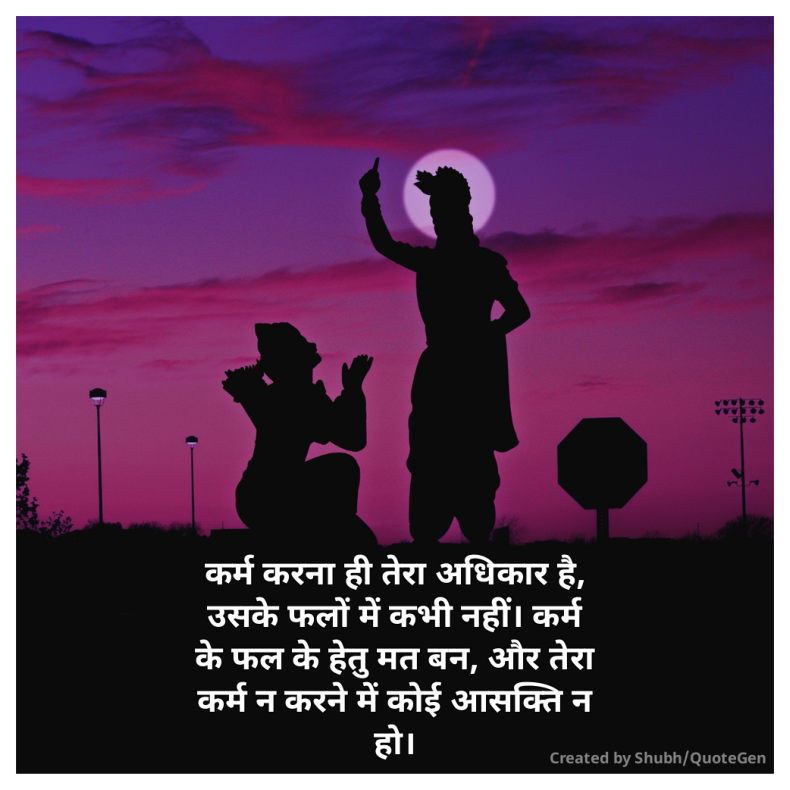

In [ ]:
import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont
import textwrap
import os
from google.colab import files
import io
import matplotlib.pyplot as plt
from string import ascii_letters
import concurrent.futures
from numba import jit, cuda
import chardet
import logging

# Set up logging
logging.basicConfig(filename='quote_generator.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

def log_error(message):
    logging.error(message)
    print(f"Error: {message}")

def detect_encoding(file_path):
    """Detects the encoding of a file."""
    with open(file_path, 'rb') as f:
        rawdata = f.read()
        result = chardet.detect(rawdata)
        return result['encoding']

def read_quotes_from_excel(file_path, column_name='Quote'):
    print(f"File path: {file_path}")
    print(f"File exists: {os.path.exists(file_path)}")
    print(f"File size: {os.path.getsize(file_path)} bytes")
    """Reads quotes from an Excel file, handling different encodings."""
    try:
        # Read the Excel file without specifying encoding
        df = pd.read_excel(file_path)

        if column_name not in df.columns:
            print(f"Column '{column_name}' not found. Available columns are: {', '.join(df.columns)}")
            return None

        # Ensure quotes are strings and handle encoding
        quotes = []
        for quote in df[column_name]:
            if isinstance(quote, str):
                quotes.append(quote)
            else:
                # Try to decode bytes to string if necessary
                try:
                    quotes.append(quote.decode('utf-8'))
                except (AttributeError, UnicodeDecodeError):
                    quotes.append(str(quote))

        return quotes
    except Exception as e:
        log_error(f"Error reading Excel file: {str(e)}")
        return None

def resize_image(image, target_width, target_height):
    """Resizes an image while preserving aspect ratio."""
    aspect_ratio = image.width / image.height
    if target_width / target_height > aspect_ratio:
        new_width = int(target_height * aspect_ratio)
        new_height = target_height
    else:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    return image.resize((new_width, new_height), Image.LANCZOS)




def get_hindi_font(font_path, size):
    """Gets a font that supports Hindi characters."""
    try:
        return ImageFont.truetype(font_path, size)
    except IOError:
        log_error(f"Error loading font: {font_path}")
        return ImageFont.load_default()

def get_text_dimensions(text, font):
    bbox = font.getbbox(text)
    return (bbox[2] - bbox[0], bbox[3] - bbox[1])

def ensure_unicode(text):
    """Ensures the text is in Unicode format."""
    if isinstance(text, str):
        return text
    try:
        return text.decode('utf-8')
    except UnicodeDecodeError:
        return text.decode('latin-1')

def get_optimal_font_scale(image, text, font_path, max_width, max_height, max_font_size=45, min_font_size=17, line_spacing=2):
    fontsize = max_font_size

    while fontsize >= min_font_size:
        font = get_hindi_font(font_path, fontsize)
        wrapped_text = textwrap.fill(ensure_unicode(text), width=max(1, int(max_width / (get_text_dimensions('अ', font)[0] * 0.7))))
        lines = wrapped_text.split('\n')
        total_height = (get_text_dimensions('अ', font)[1] + (get_text_dimensions('अ', font)[1] * (line_spacing - 1))) * len(lines)

        max_line_width = max(get_text_dimensions(line, font)[0] for line in lines)

        if max_line_width <= max_width and total_height <= max_height:
            return fontsize
        else:
            fontsize -= 1

    return min_font_size
def add_text_to_image(image, text, font_path, text_color=(255, 255, 255), outline_color=(0, 0, 0), line_spacing=2, max_font_size=45, bottom_margin_percentage=0.3):
    draw = ImageDraw.Draw(image)
    image_width, image_height = image.size

    # Calculate margins and text area
    left_margin = int(image_width * 0.1)
    right_margin = int(image_width * 0.1)
    bottom_margin = int(image_height * bottom_margin_percentage)
    top_margin = image_height - bottom_margin

    # Calculate text area
    text_width = image_width - left_margin - right_margin
    text_height = bottom_margin - int(image_height * 0.02)  # Leave a small padding at the bottom

    # Get optimal font size
    optimal_font_size = get_optimal_font_scale(image, text, font_path, text_width, text_height, max_font_size, line_spacing=line_spacing)
    font = get_hindi_font(font_path, optimal_font_size)

    # Wrap text
    wrapped_text = textwrap.fill(ensure_unicode(text), width=max(1, int(text_width / (get_text_dimensions('अ', font)[0] * 0.7))))
    lines = wrapped_text.split('\n')

    # Calculate total text height and starting y position
    line_height = get_text_dimensions('अ', font)[1] * line_spacing
    total_text_height = line_height * len(lines)
    y = top_margin + (bottom_margin - total_text_height) / 2  # Center text vertically within the bottom area

    # Add text outline and main text
    outline_width = max(1, int(optimal_font_size / 25))
    for line in lines:
        line_width = get_text_dimensions(line, font)[0]
        x = (image_width - line_width) / 2

        # Add outline
        for adj in range(-outline_width, outline_width + 1):
            for adj2 in range(-outline_width, outline_width + 1):
                draw.text((x+adj, y+adj2), line, font=font, fill=outline_color)

        # Add main text
        draw.text((x, y), line, font=font, fill=text_color)

        y += line_height

    return image


def add_border(image, border_size, border_color=(255, 255, 255)):
    """Adds a border to the image."""
    width, height = image.size
    new_width = width + 2 * border_size
    new_height = height + 2 * border_size
    new_image = Image.new('RGB', (new_width, new_height), border_color)
    new_image.paste(image, (border_size, border_size))
    return new_image

@jit(target_backend='cuda')
def apply_image_effect_gpu(np_image, effect):
    """Applies image effects using GPU (if available)."""
    if effect == 'sepia':
        sepia_filter = np.array([[0.272, 0.534, 0.131],
                                 [0.349, 0.686, 0.168],
                                 [0.393, 0.769, 0.189]])
        return cv2.transform(np_image, sepia_filter)
    elif effect == 'grayscale':
        return cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)
    else:
        return np_image

def apply_image_effect(image, effect='none'):
    """Applies various image effects to the image."""
    np_image = np.array(image)
    if effect == 'sepia':
        sepia_filter = np.array([[0.272, 0.534, 0.131],
                                 [0.349, 0.686, 0.168],
                                 [0.393, 0.769, 0.189]])
        sepia_image = cv2.transform(np_image, sepia_filter)
        return Image.fromarray(sepia_image)
    elif effect == 'grayscale':
        gray_image = cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)
        return Image.fromarray(gray_image).convert('RGB')
    else:
        return image

def add_watermark(image, watermark_text, font, opacity=0.5):
    watermark = Image.new('RGBA', image.size, (0,0,0,0))
    draw = ImageDraw.Draw(watermark)
    text_width, text_height = get_text_dimensions(watermark_text, font)
    x = image.width - text_width - 10
    y = image.height - text_height - 10
    draw.text((x, y), watermark_text, font=font, fill=(255,255,255,int(255*opacity)))
    return Image.alpha_composite(image.convert('RGBA'), watermark)

def generate_quote_image(quote, background_path, output_path, font_path, image_effect='none', bottom_margin_percentage=0.3, border_size=10, border_color=(255, 255, 255)):
    try:
        # Open background image
        background = Image.open(background_path).convert('RGB')

        # Resize background
        background = resize_image(background, 1000, 1000)  # Adjust size as needed

        # Add quote to image with dynamic scaling
        image_with_quote = add_text_to_image(background.copy(), quote, font_path, bottom_margin_percentage=bottom_margin_percentage)

        # Apply image effect
        image_with_effect = apply_image_effect(image_with_quote, effect=image_effect)

        # Add watermark
        watermark_font = get_hindi_font(font_path, 20)
        final_image = add_watermark(image_with_effect, "Created by Shubh/QuoteGen", watermark_font)
        final_image = add_border(final_image, border_size, border_color)

        # Save the image
        final_image.save(output_path)

        logging.info(f"Generated image: {output_path}")
        return final_image
    except Exception as e:
        log_error(f"Error generating image for quote '{quote}': {str(e)}")
        return None

def process_quote(args):
    """Processes a single quote and generates an image."""
    i, quote, background_path, font_path, output_folder, bottom_margin_percentage, border_size, border_color = args
    output_path = os.path.join(output_folder, f'quote_{i+1}.png')
    image_effect = np.random.choice(['none', 'sepia', 'grayscale'])
    generate_quote_image(quote, background_path, output_path, font_path, image_effect, bottom_margin_percentage, border_size, border_color)

def process_quotes(quotes, background_path, font_path, output_folder, bottom_margin_percentage=0.3, border_size=10, border_color=(255, 255, 255)):
    """Processes a list of quotes and generates images concurrently."""
    os.makedirs(output_folder, exist_ok=True)

    args_list = [(i, quote, background_path, font_path, output_folder, bottom_margin_percentage, border_size, border_color) for i, quote in enumerate(quotes)]

    with concurrent.futures.ThreadPoolExecutor() as executor:
        executor.map(process_quote, args_list)

def check_font_compatibility(font_path):
    """Checks if the font is compatible with Hindi text."""
    try:
        font = ImageFont.truetype(font_path, 12)
        test_text = "अआइईउऊऋऌऍऎएऐऑऒओऔकखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसह"
        font.getmask(test_text)
        logging.info(f"Font {font_path} is compatible with Hindi text.")
        return True
    except Exception as e:
        log_error(f"Font {font_path} is not compatible with Hindi text: {str(e)}")
        return False

def display_sample_image(output_folder):
    """Displays a sample generated image."""
    sample_image_path = os.path.join(output_folder, 'quote_1.png')
    if os.path.exists(sample_image_path):
        sample_image = Image.open(sample_image_path)
        plt.figure(figsize=(10, 10))
        plt.imshow(sample_image)
        plt.axis('off')
        plt.show()
    else:
        print("No sample image available to display.")

def main():

    print("Uploading Excel file...")
    uploaded = files.upload()
    excel_file = list(uploaded.keys())[0]

    print("Uploading background image...")
    uploaded = files.upload()
    background_file = list(uploaded.keys())[0]

    print("Uploading font file (must support Hindi)...")
    uploaded = files.upload()
    font_file = list(uploaded.keys())[0]

    if not check_font_compatibility(font_file):
        print("Please upload a font file that supports Hindi.")
        return

    column_name = input("Enter the name of the column containing quotes (default is 'Quote'): ") or 'Quote'

    quotes = read_quotes_from_excel(excel_file, column_name)
    if quotes is None:
        return

    output_folder = 'quote_images'

    bottom_margin_percentage = float(input("Enter the percentage of the image height for the bottom text area (e.g., 0.2 for 20%): ") or 0.2)
    border_size = int(input("Enter the border size in pixels (e.g., 10): ") or 10)
    border_color_input = input("Enter the border color (white/black/custom): ").lower()

    if border_color_input == 'white':
        border_color = (255, 255, 255)
    elif border_color_input == 'black':
        border_color = (0, 0, 0)
    else:
        r = int(input("Enter Red value (0-255): "))
        g = int(input("Enter Green value (0-255): "))
        b = int(input("Enter Blue value (0-255): "))
        border_color = (r, g, b)

    process_quotes(quotes, background_file, font_file, output_folder, bottom_margin_percentage, border_size, border_color)


    print("Zipping output images...")
    !zip -r {output_folder}.zip {output_folder}

    print("Downloading zipped images...")
    files.download(f'{output_folder}.zip')

    display_sample_image(output_folder)

if __name__ == "__main__":
    main()